# 3. Predictive Modeling

Ultimate is interested in predicting **rider retention**. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. 

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file `ultimate_data_challenge.json`. 

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).


In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pprint import pprint

In [367]:
# import the data
data = pd.read_json('./data/ultimate.json')

In [368]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [369]:
# Get info about cols
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [370]:
# Get descriptive statistics
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Check For Missing Values

In [371]:
# Check for null values
data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [372]:
# Handle missing data for driver ratings
mask = data.avg_rating_of_driver.isnull() | data.avg_rating_by_driver.isnull() | data.phone.isnull()
missing_rows = data[mask].shape[0]

# Check percentage of missing rows 
pct_missing = missing_rows / data.shape[0] * 100
pct_missing

17.11

Handle Missing Values

In [373]:
# Fill missing phone values with None
data['phone'] = data['phone'].fillna('None')

In [374]:
# Replace missing values with 0 for numeric cols
data = data.fillna(0)
data.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

#### Explore Categorical Features

In [375]:
# Analyze categorical data
categorical_features = data.select_dtypes('object')
categorical_features.head()

,city,signup_date,last_trip_date,phone
0,King's Landing,2014-01-25,2014-06-17,iPhone
1,Astapor,2014-01-29,2014-05-05,Android
2,Astapor,2014-01-06,2014-01-07,iPhone
3,King's Landing,2014-01-10,2014-06-29,iPhone
4,Winterfell,2014-01-27,2014-03-15,Android


In [376]:
categorical_features.dtypes

city              object
signup_date       object
last_trip_date    object
phone             object
dtype: object

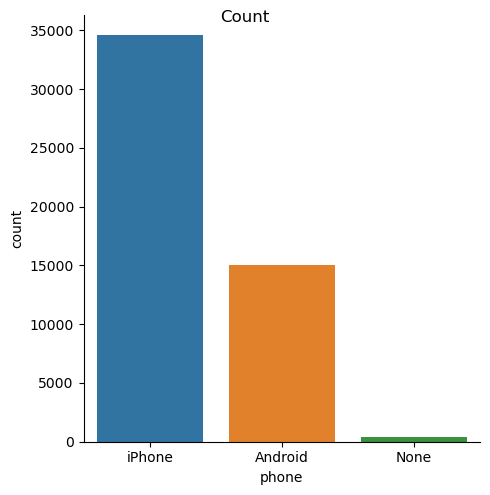

In [377]:
# Visualize counts for Phone
phones = sns.catplot(data=data, x='phone', kind='count')
phones.fig.suptitle('Count');

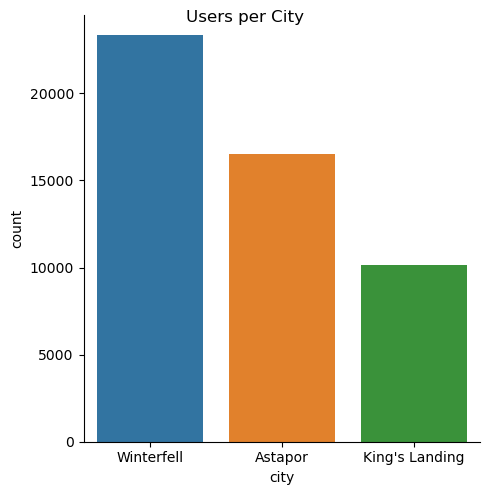

In [378]:
# Visualize Counts for City
cities = sns.catplot(data=data, x='city', kind='count', 
                     order=['Winterfell', 'Astapor', "King's Landing"])
cities.fig.suptitle('Users per City')
plt.show()

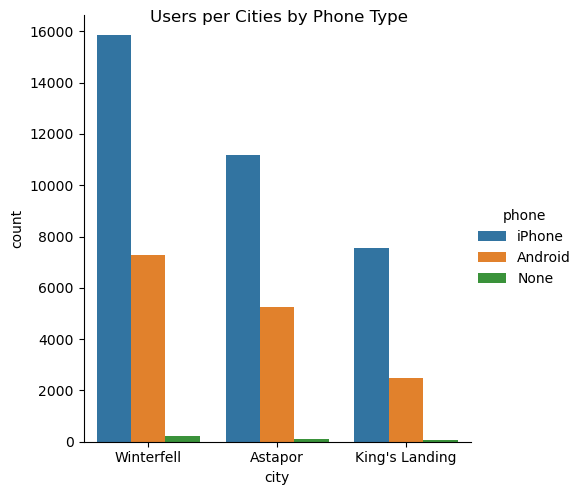

In [379]:
# Plot phone users in each city
phones_by_cities = sns.catplot(data=data, x='city', hue='phone', kind='count', 
                               order=['Winterfell', 'Astapor', "King's Landing"])
phones_by_cities.fig.suptitle('Users per Cities by Phone Type')
plt.show()

From the plots, it seems that:
* There are more Iphone users than Android users
* There are more users in Winterfell > Astapor > King's Landing
* And that trend follows for Iphone vs. Android users in the three cities

In [380]:
# Convert dates to datetime objects
data['signup_date'] = pd.to_datetime(data['signup_date'], format='%Y-%m-%d')
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'], format='%Y-%m-%d')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Explore Numerical Features

In [381]:
numerical_features = data.select_dtypes(include=['number', 'bool'])
numerical_features.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9


In [382]:
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  bool   
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1)
memory usage: 2.7 MB


In [383]:
def plot_hist(col, data=numerical_features):
    data[col].hist(histtype='step', bins=20, grid=False, density=True)

    plt.axvline(data[col].mean(), c='r', label='Mean')
    plt.axvline(data[col].median(), c='g', linestyle="--", label='Median')
    plt.legend()


In [384]:
numerical_features.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,3.854082,1.074764,8.849536,60.926084,5.796827,4.758950
std,3.792684,1.788881,0.222336,19.958811,37.081503,5.707357,0.538617
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


### Get Active and Inactive Users

A user is considered active if they have taken in the last 30 days. An inactive user is one who hasn't taken a trip in the last 30 days.

In [385]:
data[data['signup_date'] != data['last_trip_date']]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,0.0,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [386]:
data['six_months'] = data['signup_date'].apply(lambda x: pd.to_datetime('{}-07-{}'.format(x.year,x.day)))
data.six_months

0       2014-07-25
1       2014-07-29
2       2014-07-06
3       2014-07-10
4       2014-07-27
           ...    
49995   2014-07-25
49996   2014-07-24
49997   2014-07-31
49998   2014-07-14
49999   2014-07-18
Name: six_months, Length: 50000, dtype: datetime64[ns]

In [387]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,six_months
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-07-25
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-07-29
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-07-06
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-07-10
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-07-27


In [388]:

# Find our target feature: Whether a user has taken a ride within 30 days after 6 months
data['active'] = data['six_months'] - data['last_trip_date'] < pd.Timedelta('30 days')
data[data.active == True]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,six_months,active
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-07-10,True
16,King's Landing,1,2014-01-11,5.0,1.00,2014-06-28,Android,0.0,True,50.0,10.86,3.0,2014-07-11,True
17,King's Landing,0,2014-01-12,3.9,1.00,2014-07-01,iPhone,0.0,True,95.2,2.38,4.8,2014-07-12,True
19,King's Landing,0,2014-01-02,5.0,1.17,2014-06-03,iPhone,33.3,False,66.7,12.08,5.0,2014-07-02,True
32,Winterfell,1,2014-01-05,4.0,2.00,2014-06-10,iPhone,100.0,False,100.0,10.01,5.0,2014-07-05,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,Astapor,2,2014-01-01,4.0,1.00,2014-06-28,iPhone,0.0,True,25.0,4.07,5.0,2014-07-01,True
49975,Winterfell,11,2014-01-11,3.9,1.03,2014-06-18,iPhone,4.1,False,91.8,2.18,4.8,2014-07-11,True
49976,King's Landing,0,2014-01-21,2.0,1.00,2014-07-01,iPhone,0.0,False,100.0,2.39,4.0,2014-07-21,True
49991,Winterfell,0,2014-01-08,5.0,1.25,2014-06-29,iPhone,100.0,False,0.0,1.06,5.0,2014-07-08,True


We have about ~11.6k users that meets our definition of an active user, wherein they took a trip in the preceeding 30 days of their 6th month using the ridesharing service.

In [389]:
# Map True values to 1 and False values to 0
data['active'] = data['active'].replace([True, False], [1, 0])

In [390]:
# Get percentage of active users
pd.DataFrame(data.active.value_counts(normalize=True)).T

,0,1
active,0.76612,0.23388


From the percentages above, we have about 23% of users that meet the definition of active, and 77% that don't.

### Feature Matrix and Target Labels

In [391]:
X = data.drop('active', axis=1).select_dtypes(exclude=['datetime'])
y = data.active

In [392]:
X.shape

(50000, 10)

In [393]:
y.shape

(50000,)

Encode Categorical Variables

In [394]:
X = pd.get_dummies(X)

In [395]:
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_None,phone_iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,0,1,0,0,0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,1,0,0,1,0,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,1,0,0,0,0,1
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,0,1,0,0,0,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,0,1,1,0,0


Perform Train/Test split

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [397]:
# Verify active user proportion preserved in train split
y_train.value_counts(normalize=True).T

0    0.766114
1    0.233886
Name: active, dtype: float64

In [398]:
# verify active user proportion preserved in test split
y_test.value_counts(normalize=True).T

0    0.766133
1    0.233867
Name: active, dtype: float64

## Modeling

In [399]:
# Normalize Numeric Cols

# Step 1: Fit the scaler on the training set
scaler = StandardScaler()
scaler.fit(X_train.select_dtypes(exclude=['datetime']))

# Step 2: Transform the training set
X_train_scaled = scaler.transform(X_train.select_dtypes(exclude=['datetime']))

# Step 3: Transform the test set using the same scaler
X_test_scaled = scaler.transform(X_test.select_dtypes(exclude=['datetime']))

In [400]:
X_train_scaled

array([[-0.33370586,  0.64024352, -0.33234122, ..., -0.65692571,
        -0.09092742,  0.66974292],
       [-0.59446013,  0.64024352, -0.33234122, ...,  1.52224213,
        -0.09092742, -1.49311021],
       [-0.59446013,  0.64024352, -0.33234122, ..., -0.65692571,
        -0.09092742,  0.66974292],
       ...,
       [ 1.49157401,  0.36152846,  0.24602596, ..., -0.65692571,
        -0.09092742,  0.66974292],
       [ 1.49157401,  0.64024352, -0.06540252, ...,  1.52224213,
        -0.09092742, -1.49311021],
       [ 0.44855694,  0.64024352, -0.33234122, ..., -0.65692571,
        -0.09092742,  0.66974292]])

## Model Selection and Training

### Random Forest Classifier

In [401]:
# baseline RF classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [402]:
preds = rf.predict(X_test_scaled)

In [403]:
# Evaluate predictions
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score


def get_metrics(y_preds, y_true=y_test):
    '''Returns the accuracy, confusion matrix and recall scores as a tuple.'''
    accuracy = accuracy_score(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    auc = roc_auc_score(y_true, y_preds)

    return (accuracy, cm, auc, recall)


def print_metrics(y_preds, y_true=y_test):
    accuracy, cm, auc, recall = get_metrics(y_preds)
    print(f"The accuracy score is: {accuracy}")
    print(f"The confusion matrix is: \n {cm})")
    print(f"The AUC score is: {auc}")
    print(f"The recall score is: {recall}")

print("Metrics for Baseline RF Classifier: \n")
print_metrics(preds)

Metrics for Baseline RF Classifier: 

The accuracy score is: 0.7766666666666666
The confusion matrix is: 
 [[10226  1266]
 [ 2084  1424]])
The AUC score is: 0.6478828561914668
The recall score is: 0.40592930444697833


Hyperparameter Tuning

In [404]:
# Define parameter grid

n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]


param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

pprint(param_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [405]:
# Define Grid Search CV
from sklearn.model_selection import RandomizedSearchCV

cv = RandomizedSearchCV(estimator=rf, 
                  param_distributions=param_grid, 
                  cv=5,
                  scoring='recall',
                  n_jobs=-1,
                  verbose=1)

In [406]:
# Fit training data
cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='recall', verbose=1)

In [407]:
# Get best model and params
best_rf = cv.best_estimator_
pprint(cv.best_params_)

{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}


In [408]:
# Evaluate best classifier from CV
best_preds = best_rf.predict(X_test_scaled)

# Evaluate with same metrics
rf_metrics = get_metrics(best_preds, y_test)
print_metrics(best_preds)

The accuracy score is: 0.7777333333333334
The confusion matrix is: 
 [[10206  1286]
 [ 2048  1460]])
The AUC score is: 0.652143814486385
The recall score is: 0.4161915621436716


In [409]:
# Get feature importances

def get_important_features(estimator, feature_matrix=X):
    important_features = estimator.feature_importances_

    # Get sorted indices of features
    sorted_indices = important_features.argsort()

    # Get feature names
    feature_names = feature_matrix.columns

    return (important_features, sorted_indices, feature_names)

important_features, sorted_indices, feature_names = get_important_features(best_rf)

In [410]:
# Get top 3 Features
top_3_rf_features = feature_names[sorted_indices][::-1][:3].to_list()

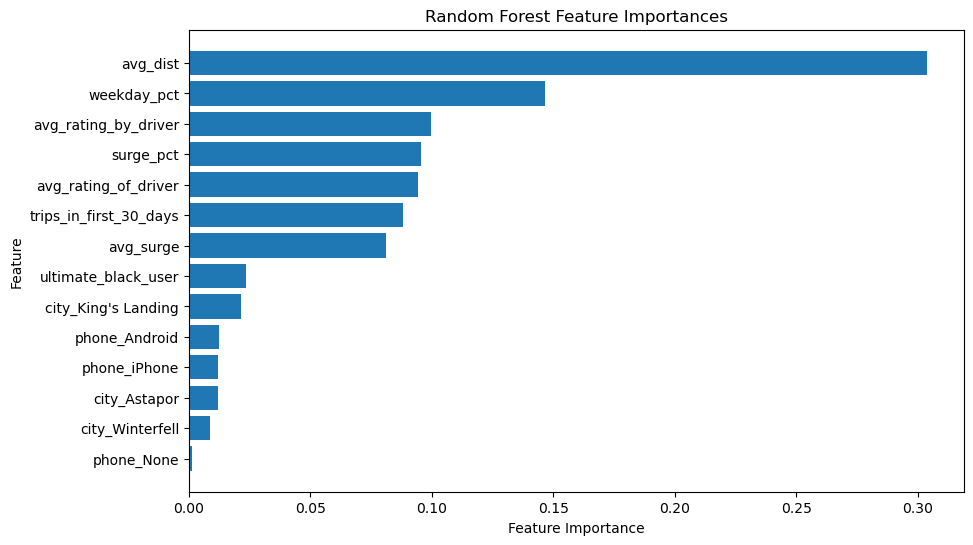

In [411]:
# Visualize Important Features
# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)),
         important_features[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [
           feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

### Create Pipeline for LogReg Model

In [412]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

steps = [
    ('scaler', StandardScaler()), 
    ('LogReg', LogisticRegression())]

pipeline = Pipeline(steps)

### Baseline Logistic Regression Model

In [413]:
# Get BaseLine Logreg Model
pipeline.fit(X_train, y_train)

# predict values
lr_preds = pipeline.predict(X_test)

# Evaluate predictions
print_metrics(lr_preds)

The accuracy score is: 0.7753333333333333
The confusion matrix is: 
 [[11035   457]
 [ 2913   595]])
The AUC score is: 0.5649227602087775
The recall score is: 0.16961231470923605


Perform Hyperparam Tuning with Randomized CV

In [414]:
lr = LogisticRegression()

penalty = ['l2']
C = [0.001, 0.01, 0.1, 1, 10]
solver = ['liblinear', 'newton-cg', 'saga', 'sag']
max_iter = [100, 150, 200, 250, 300, 400, 500]
param_grid = {
    'penalty': penalty,
    'C': C,
    'solver': solver,
    'max_iter': max_iter
}

pprint(param_grid)

{'C': [0.001, 0.01, 0.1, 1, 10],
 'max_iter': [100, 150, 200, 250, 300, 400, 500],
 'penalty': ['l2'],
 'solver': ['liblinear', 'newton-cg', 'saga', 'sag']}


In [415]:
# Perform Random CV

lr_cv = RandomizedSearchCV(lr, 
                           param_distributions=param_grid, 
                           cv=5,
                           scoring='recall',
                           n_jobs=-1, 
                           verbose=1)

lr_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'max_iter': [100, 150, 200, 250, 300,
                                                     400, 500],
                                        'penalty': ['l2'],
                                        'solver': ['liblinear', 'newton-cg',
                                                   'saga', 'sag']},
                   scoring='recall', verbose=1)

In [416]:
# Find best model and params
best_lr = lr_cv.best_estimator_

print(f"The best parameters are: {lr_cv.best_params_}")

The best parameters are: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 150, 'C': 1}


In [417]:
# Evaluate Best Model
best_preds = best_lr.predict(X_test)

lr_metrics = get_metrics(best_preds)
print_metrics(best_preds)

The accuracy score is: 0.6984
The confusion matrix is: 
 [[8980 2512]
 [2012 1496]])
The AUC score is: 0.6039334884095664
The recall score is: 0.4264538198403649


/Users/kylerodriguez/miniconda3/envs/employee-attrition/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [418]:
# Get Important Features
# Get feature names (assuming X is a DataFrame)
feature_names = X.columns

# Create a DataFrame with feature names and corresponding coefficients
coef_df = pd.DataFrame(
    {'Feature': feature_names, 'Coefficient': best_lr.coef_[0]})

coef_df['AbsoluteCoefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='AbsoluteCoefficient', ascending=True)

In [419]:
# Get top 3 Feature Names
top_3_lr_features = coef_df[::-1][:3].drop('Coefficient', axis=1)['Feature'].to_list()

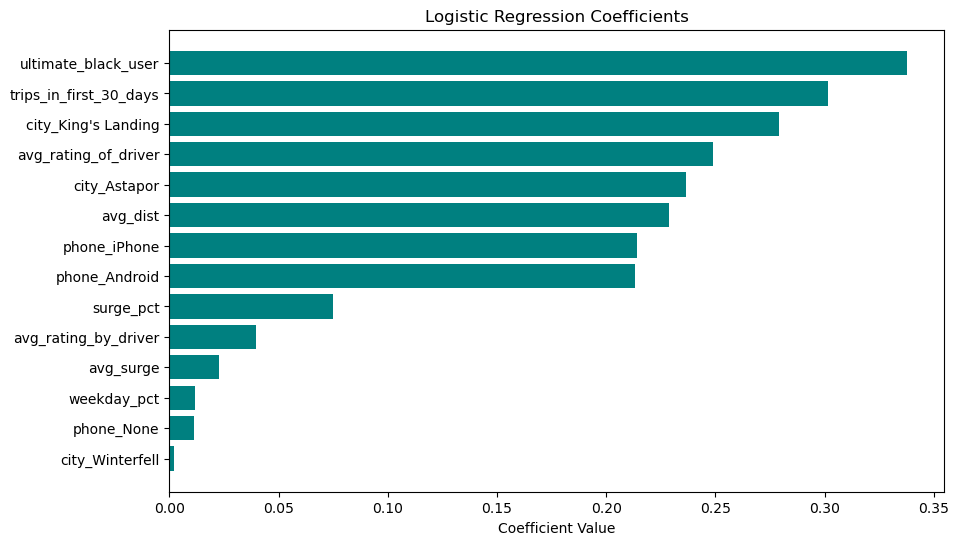

In [420]:
# Visualize Important Features
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['AbsoluteCoefficient'], color='teal')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

### KNN Classifier

In [421]:
# Baseline model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train_scaled, y_train)

knn_preds = knn.predict(X_test_scaled)

In [422]:
# Evaluate Model 
print_metrics(knn_preds)

The accuracy score is: 0.7704
The confusion matrix is: 
 [[10137  1355]
 [ 2089  1419]])
The AUC score is: 0.6432979404442176
The recall score is: 0.40450399087799316


Hyperparam Tuning

In [423]:
# Parameters
grid = {
    'n_neighbors': [1,3,5,7,9],
    'weights':['uniform', 'distance']},

knn_cv = RandomizedSearchCV(knn, 
                            param_distributions=grid, 
                            n_jobs=-1, 
                            verbose=1, 
                            cv=5, 
                            scoring='recall')

knn_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions=({'n_neighbors': [1, 3, 5, 7, 9],
                                         'weights': ['uniform', 'distance']},),
                   scoring='recall', verbose=1)

In [424]:
# Get best model and params
best_knn = knn_cv.best_estimator_

knn_preds = best_knn.predict(X_test_scaled)
pprint(knn_cv.best_params_)

{'n_neighbors': 1, 'weights': 'uniform'}


In [425]:
# Evaluate metrics

knn_metrics = get_metrics(knn_preds)
print_metrics(knn_preds)

The accuracy score is: 0.7254
The confusion matrix is: 
 [[9398 2094]
 [2025 1483]])
The AUC score is: 0.6202671453365407
The recall score is: 0.4227480045610034


In [426]:
# Get Important Features
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(best_knn, 
                                         X_test_scaled, 
                                         y_test, 
                                         n_repeats=30)

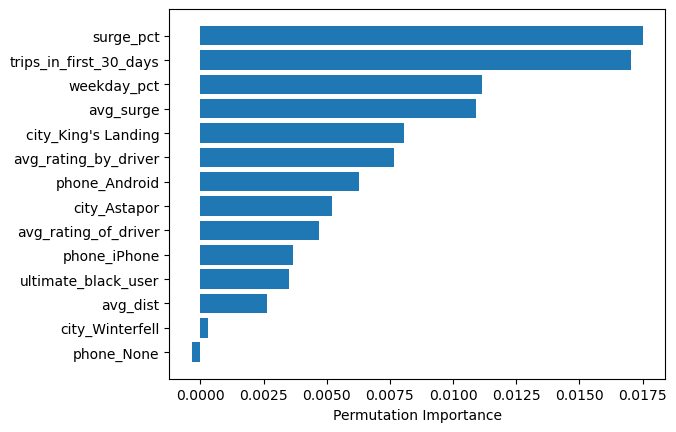

In [427]:
# Visualize feature importances
feature_names = X.columns
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(range(X.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(X.shape[1]), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

In [428]:
# Get top 3 features
knn_features = [{'feature': feature_names[i], 'idx': i} for i in sorted_idx]
knn_features = sorted(knn_features, key= lambda x: x['idx'])
knn_features

[{'feature': 'trips_in_first_30_days', 'idx': 0},
 {'feature': 'avg_rating_of_driver', 'idx': 1},
 {'feature': 'avg_surge', 'idx': 2},
 {'feature': 'surge_pct', 'idx': 3},
 {'feature': 'ultimate_black_user', 'idx': 4},
 {'feature': 'weekday_pct', 'idx': 5},
 {'feature': 'avg_dist', 'idx': 6},
 {'feature': 'avg_rating_by_driver', 'idx': 7},
 {'feature': 'city_Astapor', 'idx': 8},
 {'feature': "city_King's Landing", 'idx': 9},
 {'feature': 'city_Winterfell', 'idx': 10},
 {'feature': 'phone_Android', 'idx': 11},
 {'feature': 'phone_None', 'idx': 12},
 {'feature': 'phone_iPhone', 'idx': 13}]

In [429]:
features = [i['feature'] for i in knn_features]
importances = [i['idx'] for i in knn_features] 
top_3_knn_features = pd.DataFrame(data={'features':feature_names, 'importances':importances})[:3]

## Conclusion

In [430]:
top_3_knn_features = top_3_knn_features['features'].to_list()

In [431]:
top_3_knn_features

['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge']

In [435]:
index = ['Random Forest', 'Logistic Regression', 'KNN']
data = {
    'accuracy score': [rf_metrics[0], lr_metrics[0], knn_metrics[0]],
    'auc score': [rf_metrics[2], lr_metrics[2], knn_metrics[2]],
    'recall score': [rf_metrics[3], lr_metrics[3], knn_metrics[3]],
    'top feature': [top_3_rf_features[0], top_3_lr_features[0], top_3_knn_features[0]],
    'second feature': [top_3_rf_features[1], top_3_lr_features[1], top_3_knn_features[1]],
    'third feature': [top_3_rf_features[2], top_3_lr_features[2], top_3_knn_features[2]]
}

features_and_metrics_summary = pd.DataFrame(data=data, index=index)

In [437]:
features_and_metrics_summary.sort_values(by='auc score', ascending=False)

,accuracy score,auc score,recall score,top feature,second feature,third feature
Random Forest,0.777733,0.652144,0.416192,avg_dist,weekday_pct,avg_rating_by_driver
KNN,0.725400,0.620267,0.422748,trips_in_first_30_days,avg_rating_of_driver,avg_surge
Logistic Regression,0.698400,0.603933,0.426454,ultimate_black_user,trips_in_first_30_days,city_King's Landing


From the models tried, the best scoring model across all metrics is the Random Forest model which has an accuracy of 0.78, and AUC score of 0.65 and a recall score of about 0.42. 

It's top features included the number of trips taken in the first 30 days, the average rating of the driver and the average surge multiplier.

Some further tuning and maybe a request for more data may help improve these scores.